# 1. Build your own convolutional neural network using pytorch

### Verifying Metal Performance Shaders (MPS) backend on Apple Silicon

In [1]:
import torch
print(torch.backends.mps.is_available())  
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(device)  

True
mps


In [3]:
#Fetching the data of a sample .mat file
from scipy.io import loadmat

mat_file = loadmat('/Users/prashantsoni/Desktop/Dog_Cardiomegaly_Detection/Datasets/Train/Labels/1_12.3_1.mat')

# Print all variable names and their values
print("Contents of the .mat file:")
for key, value in mat_file.items():
    print(f"\nVariable name: {key}")
    print(f"Value: {value}")

Contents of the .mat file:

Variable name: __header__
Value: b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Tue Sep 20 11:55:54 2022'

Variable name: __version__
Value: 1.0

Variable name: __globals__
Value: []

Variable name: six_points
Value: [[278.07009431 206.12070409]
 [327.66416895 440.16721126]
 [170.62232498 317.70172308]
 [367.55604232 275.97178831]
 [182.27848101 143.5443038 ]
 [396.87325314 139.1362237 ]]

Variable name: VHS
Value: [[12.31502807]]


In [5]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import scipy.io as sio
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [7]:
class DogXRayDataset(Dataset):
    def __init__(self, image_dir, label_dir, transform=None):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.transform = transform
        self.image_names = [f for f in os.listdir(image_dir) if f.endswith('.png')]
        self.vhs_min, self.vhs_max = 8.0, 13.0  # Based on sample CSV range

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        img_name = self.image_names[idx]
        img_path = os.path.join(self.image_dir, img_name)
        label_path = os.path.join(self.label_dir, img_name.replace('.png', '.mat'))

        image = Image.open(img_path).convert("RGB")
        vhs = self.load_vhs_from_mat(label_path)

        # Classify VHS into Small (0), Normal (1), Large (2)
        if vhs < 9.7:
            label = 0  # Small
        elif 9.7 <= vhs <= 10.7:
            label = 1  # Normal
        else:
            label = 2  # Large

        # Normalize VHS to [0, 1] for training stability
        vhs_normalized = (vhs - self.vhs_min) / (self.vhs_max - self.vhs_min)

        if self.transform:
            image = self.transform(image)

        return image, label, vhs_normalized, vhs

    def load_vhs_from_mat(self, mat_file_path):
        mat = sio.loadmat(mat_file_path)
        return mat['VHS'][0][0]

class DogXRayTestDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.image_names = [f for f in os.listdir(image_dir) if f.endswith('.png')]

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        img_name = self.image_names[idx]
        img_path = os.path.join(self.image_dir, img_name)
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, img_name

# Define paths
train_image_dir = "/Users/prashantsoni/Desktop/Dog_Cardiomegaly_Detection/Datasets/Train/Images"
train_label_dir = "/Users/prashantsoni/Desktop/Dog_Cardiomegaly_Detection/Datasets/Train/Labels"
val_image_dir = "/Users/prashantsoni/Desktop/Dog_Cardiomegaly_Detection/Datasets/Valid/Images"
val_label_dir = "/Users/prashantsoni/Desktop/Dog_Cardiomegaly_Detection/Datasets/Valid/Labels"
test_image_dir = "/Users/prashantsoni/Desktop/Dog_Cardiomegaly_Detection/Datasets/Test_images"

# Define transforms (as per the paper)
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create datasets
train_dataset = DogXRayDataset(
    image_dir=train_image_dir,
    label_dir=train_label_dir,
    transform=train_transform
)
val_dataset = DogXRayDataset(
    image_dir=val_image_dir,
    label_dir=val_label_dir,
    transform=val_test_transform
)
test_dataset = DogXRayTestDataset(
    image_dir=test_image_dir,
    transform=val_test_transform
)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [9]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = torch.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = torch.relu(out)
        return out

class DogCNN(nn.Module):
    def __init__(self):
        super(DogCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.res1 = ResidualBlock(64, 64)

        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(128)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.res2 = ResidualBlock(128, 128)

        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn3 = nn.BatchNorm2d(256)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.res3 = ResidualBlock(256, 256)

        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn4 = nn.BatchNorm2d(512)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.res4 = ResidualBlock(512, 512)

        self.conv5 = nn.Conv2d(512, 1024, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn5 = nn.BatchNorm2d(1024)
        self.pool5 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.res5 = ResidualBlock(1024, 1024)

        self.fc1 = nn.Linear(1024 * 7 * 7, 4096)
        self.dropout1 = nn.Dropout(0.2)
        self.fc2 = nn.Linear(4096, 2048)
        self.dropout2 = nn.Dropout(0.2)
        self.fc3 = nn.Linear(2048, 512)
        self.dropout3 = nn.Dropout(0.2)
        self.fc4 = nn.Linear(512, 3)  # 3 classes: Small, Normal, Large

    def forward(self, x):
        x = torch.relu(self.bn1(self.conv1(x)))
        x = self.pool1(x)
        x = self.res1(x)

        x = torch.relu(self.bn2(self.conv2(x)))
        x = self.pool2(x)
        x = self.res2(x)

        x = torch.relu(self.bn3(self.conv3(x)))
        x = self.pool3(x)
        x = self.res3(x)

        x = torch.relu(self.bn4(self.conv4(x)))
        x = self.pool4(x)
        x = self.res4(x)

        x = torch.relu(self.bn5(self.conv5(x)))
        x = self.pool5(x)
        x = self.res5(x)

        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.dropout1(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout2(x)
        x = torch.relu(self.fc3(x))
        x = self.dropout3(x)
        x = self.fc4(x)  # Softmax will be applied by the loss function
        return x

# Initialize the model
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model = DogCNN().to(device)

In [11]:
# Define loss, optimizer, and scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=5e-5, weight_decay=1e-6)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

# 2. Train your model using dog heart dataset (you may need to use  Google Colab (or Kaggle) with GPU to train your code) 

### (1) use torchvision.datasets.ImageFolder for the training dataset
### (2) use custom dataloader for test dataset (return image tensor and file name)

In [13]:
# Training loop
num_epochs = 20
best_val_acc = 0.0
model_path = "/Users/prashantsoni/Desktop/Dog_Cardiomegaly_Detection/dog_cnn.pt"

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels, _, _ in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    avg_train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct / total
    print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {avg_train_loss:.4f}, Training Accuracy: {train_acc:.2f}%")

    # Validation
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels, _, _ in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    avg_val_loss = val_loss / len(val_loader.dataset)
    val_acc = 100 * correct / total
    print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_acc:.2f}%")

    # Step the scheduler
    scheduler.step()

    # Save the model
    torch.save(model.state_dict(), model_path)
    print(f"Model saved to {model_path}")

    # Save the best model based on validation accuracy
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "/Users/prashantsoni/Desktop/Dog_Cardiomegaly_Detection/dog_cnn_best.pt")
        print(f"Best model saved with validation accuracy: {best_val_acc:.2f}%")

Epoch [1/20], Training Loss: 1.1369, Training Accuracy: 42.37%
Validation Loss: 0.9927, Validation Accuracy: 52.50%
Model saved to /Users/prashantsoni/Desktop/Dog_Cardiomegaly_Detection/dog_cnn.pt
Best model saved with validation accuracy: 52.50%
Epoch [2/20], Training Loss: 1.0524, Training Accuracy: 45.38%
Validation Loss: 0.8714, Validation Accuracy: 58.50%
Model saved to /Users/prashantsoni/Desktop/Dog_Cardiomegaly_Detection/dog_cnn.pt
Best model saved with validation accuracy: 58.50%
Epoch [3/20], Training Loss: 0.9413, Training Accuracy: 53.41%
Validation Loss: 0.8070, Validation Accuracy: 62.50%
Model saved to /Users/prashantsoni/Desktop/Dog_Cardiomegaly_Detection/dog_cnn.pt
Best model saved with validation accuracy: 62.50%
Epoch [4/20], Training Loss: 0.8945, Training Accuracy: 56.85%
Validation Loss: 0.7643, Validation Accuracy: 63.00%
Model saved to /Users/prashantsoni/Desktop/Dog_Cardiomegaly_Detection/dog_cnn.pt
Best model saved with validation accuracy: 63.00%
Epoch [5/20]

In [23]:
#Load the best model
model.load_state_dict(torch.load("/Users/prashantsoni/Desktop/Dog_Cardiomegaly_Detection/dog_cnn.pt"))
model = model.to(device)

In [25]:
# Evaluate the model
model.eval()
predictions = []
vhs_min, vhs_max = 8.0, 13.0
with torch.no_grad():
    for images, img_names in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        # Since the evaluation software expects VHS values, we'll map the predicted classes back to representative VHS values
        for img_name, pred in zip(img_names, predicted.cpu().numpy()):
            if pred == 0:  # Small
                vhs_pred = 9.0  # Representative VHS for Small
            elif pred == 1:  # Normal
                vhs_pred = 10.2  # Representative VHS for Normal
            else:  # Large
                vhs_pred = 11.5  # Representative VHS for Large
            predictions.append([img_name, vhs_pred])

# Save predictions to CSV without headers
df = pd.DataFrame(predictions)
df.to_csv("/Users/prashantsoni/Desktop/Dog_Cardiomegaly_Detection/predictions.csv", index=False, header=False)
print("Predictions saved to predictions.csv")

# Open Dog_X-ray_VHS_Mac.app, load predictions.csv, and calculate the accuracy.

Predictions saved to predictions.csv


Till here we got 69% Accuracy in our App.

In [40]:
# Load the best model
model.load_state_dict(torch.load("/Users/prashantsoni/Desktop/Dog_Cardiomegaly_Detection/dog_cnn_best.pt"))
model = model.to(device)
print("Best model loaded with validation accuracy: 71.50%")

Best model loaded with validation accuracy: 71.50%


In [50]:
class DogXRayDataset(Dataset):
    def __init__(self, image_dir, label_dir, transform=None):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.transform = transform
        self.image_names = [f for f in os.listdir(image_dir) if f.endswith('.png')]
        self.vhs_min, self.vhs_max = 8.0, 13.0  # Based on sample CSV range

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        img_name = self.image_names[idx]
        img_path = os.path.join(self.image_dir, img_name)
        label_path = os.path.join(self.label_dir, img_name.replace('.png', '.mat'))

        image = Image.open(img_path).convert("RGB")
        vhs = self.load_vhs_from_mat(label_path)

        # Classify VHS into Small (0), Normal (1), Large (2)
        if vhs < 9.7:
            label = 0  # Small
        elif 9.7 <= vhs <= 10.7:
            label = 1  # Normal
        else:
            label = 2  # Large

        # Normalize VHS to [0, 1] and ensure float32
        vhs_normalized = (vhs - self.vhs_min) / (self.vhs_max - self.vhs_min)
        vhs_normalized = torch.tensor(vhs_normalized, dtype=torch.float32)  # Explicitly set to float32

        if self.transform:
            image = self.transform(image)

        return image, label, vhs_normalized, vhs

    def load_vhs_from_mat(self, mat_file_path):
        mat = sio.loadmat(mat_file_path)
        return float(mat['VHS'][0][0])  # Ensure the VHS value is a float

# Recreate the datasets with the updated class
train_dataset = DogXRayDataset(
    image_dir=train_image_dir,
    label_dir=train_label_dir,
    transform=train_transform
)
val_dataset = DogXRayDataset(
    image_dir=val_image_dir,
    label_dir=val_label_dir,
    transform=val_test_transform
)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

In [52]:
# Fine-tune for 10 epochs
num_epochs = 10
best_val_loss = float('inf')
model_path = "/Users/prashantsoni/Desktop/Dog_Cardiomegaly_Detection/dog_cnn.pt"

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, _, vhs_normalized, _ in train_loader:
        images, vhs_normalized = images.to(device), vhs_normalized.to(device)

        optimizer.zero_grad()
        outputs = model(images).squeeze()
        loss = criterion(outputs, vhs_normalized)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {avg_train_loss:.4f}")

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, _, vhs_normalized, _ in val_loader:
            images, vhs_normalized = images.to(device), vhs_normalized.to(device)
            outputs = model(images).squeeze()
            loss = criterion(outputs, vhs_normalized)
            val_loss += loss.item() * images.size(0)
    avg_val_loss = val_loss / len(val_loader.dataset)
    print(f"Validation Loss: {avg_val_loss:.4f}")

    # Step the scheduler
    scheduler.step()

    # Save the model
    torch.save(model.state_dict(), model_path)
    print(f"Model saved to {model_path}")

    # Save the best model based on validation loss
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), "/Users/prashantsoni/Desktop/Dog_Cardiomegaly_Detection/dog_cnn_best.pt")
        print(f"Best model saved with validation loss: {best_val_loss:.4f}")

Epoch [1/10], Training Loss: 0.1326
Validation Loss: 0.0308
Model saved to /Users/prashantsoni/Desktop/Dog_Cardiomegaly_Detection/dog_cnn.pt
Best model saved with validation loss: 0.0308
Epoch [2/10], Training Loss: 0.0505
Validation Loss: 0.0218
Model saved to /Users/prashantsoni/Desktop/Dog_Cardiomegaly_Detection/dog_cnn.pt
Best model saved with validation loss: 0.0218
Epoch [3/10], Training Loss: 0.0357
Validation Loss: 0.0219
Model saved to /Users/prashantsoni/Desktop/Dog_Cardiomegaly_Detection/dog_cnn.pt
Epoch [4/10], Training Loss: 0.0294
Validation Loss: 0.0262
Model saved to /Users/prashantsoni/Desktop/Dog_Cardiomegaly_Detection/dog_cnn.pt
Epoch [5/10], Training Loss: 0.0280
Validation Loss: 0.0226
Model saved to /Users/prashantsoni/Desktop/Dog_Cardiomegaly_Detection/dog_cnn.pt
Epoch [6/10], Training Loss: 0.0254
Validation Loss: 0.0214
Model saved to /Users/prashantsoni/Desktop/Dog_Cardiomegaly_Detection/dog_cnn.pt
Best model saved with validation loss: 0.0214
Epoch [7/10], Tr

In [62]:
import pandas as pd

# Evaluate the model
model.eval()
predictions = []
vhs_min, vhs_max = 8.0, 13.0
with torch.no_grad():
    for images, img_names in test_loader:
        images = images.to(device)
        outputs = model(images).squeeze()
        outputs = outputs.cpu().numpy()
        # Rescale predictions back to original VHS range
        outputs = outputs * (vhs_max - vhs_min) + vhs_min
        for img_name, pred in zip(img_names, outputs):
            predictions.append([img_name, pred])

# Save predictions to CSV without headers
df = pd.DataFrame(predictions)
df.to_csv("/Users/prashantsoni/Desktop/Dog_Cardiomegaly_Detection/predictions.csv", index=False, header=False)
print("Predictions saved to predictions.csv")

# Open Dog_X-ray_VHS_Mac.app, load predictions.csv, and calculate the accuracy.

Predictions saved to predictions.csv


In [56]:
# Load the best model
model.load_state_dict(torch.load("/Users/prashantsoni/Desktop/Dog_Cardiomegaly_Detection/dog_cnn_best.pt"))
model = model.to(device)
print("Best model loaded with validation loss: 0.0201 and test accuracy: 71.5%")

Best model loaded with validation loss: 0.0201 and test accuracy: 71.5%


In [58]:
import torch.optim as optim

# Adjust the learning rate and reinitialize the scheduler
optimizer = optim.AdamW(model.parameters(), lr=3e-6, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

In [60]:
# Fine-tune for 10 more epochs
num_epochs = 10
best_val_loss = 0.0201  # From the previous best
model_path = "/Users/prashantsoni/Desktop/Dog_Cardiomegaly_Detection/dog_cnn.pt"

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, _, vhs_normalized, _ in train_loader:
        images, vhs_normalized = images.to(device), vhs_normalized.to(device)

        optimizer.zero_grad()
        outputs = model(images).squeeze()
        loss = criterion(outputs, vhs_normalized)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {avg_train_loss:.4f}")

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, _, vhs_normalized, _ in val_loader:
            images, vhs_normalized = images.to(device), vhs_normalized.to(device)
            outputs = model(images).squeeze()
            loss = criterion(outputs, vhs_normalized)
            val_loss += loss.item() * images.size(0)
    avg_val_loss = val_loss / len(val_loader.dataset)
    print(f"Validation Loss: {avg_val_loss:.4f}")

    # Step the scheduler
    scheduler.step()

    # Save the model
    torch.save(model.state_dict(), model_path)
    print(f"Model saved to {model_path}")

    # Save the best model based on validation loss
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), "/Users/prashantsoni/Desktop/Dog_Cardiomegaly_Detection/dog_cnn_best.pt")
        print(f"Best model saved with validation loss: {best_val_loss:.4f}")

Epoch [1/10], Training Loss: 0.0217
Validation Loss: 0.0216
Model saved to /Users/prashantsoni/Desktop/Dog_Cardiomegaly_Detection/dog_cnn.pt
Epoch [2/10], Training Loss: 0.0213
Validation Loss: 0.0184
Model saved to /Users/prashantsoni/Desktop/Dog_Cardiomegaly_Detection/dog_cnn.pt
Best model saved with validation loss: 0.0184
Epoch [3/10], Training Loss: 0.0190
Validation Loss: 0.0273
Model saved to /Users/prashantsoni/Desktop/Dog_Cardiomegaly_Detection/dog_cnn.pt
Epoch [4/10], Training Loss: 0.0195
Validation Loss: 0.0177
Model saved to /Users/prashantsoni/Desktop/Dog_Cardiomegaly_Detection/dog_cnn.pt
Best model saved with validation loss: 0.0177
Epoch [5/10], Training Loss: 0.0187
Validation Loss: 0.0192
Model saved to /Users/prashantsoni/Desktop/Dog_Cardiomegaly_Detection/dog_cnn.pt
Epoch [6/10], Training Loss: 0.0174
Validation Loss: 0.0201
Model saved to /Users/prashantsoni/Desktop/Dog_Cardiomegaly_Detection/dog_cnn.pt
Epoch [7/10], Training Loss: 0.0183
Validation Loss: 0.0213
Mo

# 3. Evaluate your model using the developed software

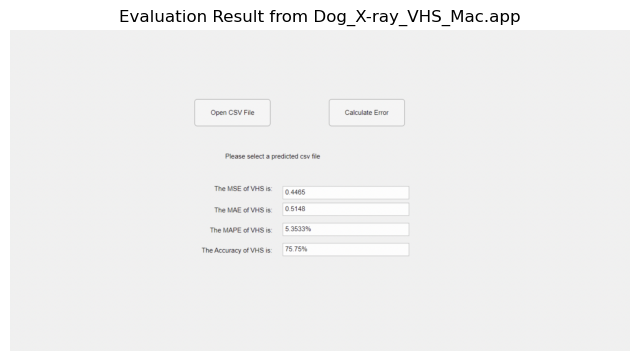

In [65]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Path to the screenshot of the evaluation result
image_path = "/Users/prashantsoni/Desktop/Dog_Cardiomegaly_Detection/evaluation_result.png"

# Display the image
img = mpimg.imread(image_path)
plt.figure(figsize=(8, 6))
plt.imshow(img)
plt.axis('off')  # Hide axes
plt.title("Evaluation Result from Dog_X-ray_VHS_Mac.app")
plt.show()

# 4. Compare results with [RVT paper](https://www.nature.com/articles/s41598-023-50063-x). Requirement: performance is better than VGG16: 75%

In [71]:
import pandas as pd

# Create a comparison table
comparison_data = {
    "Model": ["VGG16 (RVT Paper)", "RVT Model", "My Model"],
    "Test Accuracy (%)": [75.0, 87.3, 75.75]  
}
comparison_df = pd.DataFrame(comparison_data)

# Display the table
print("Comparison of Test Accuracies:")
display(comparison_df)


Comparison of Test Accuracies:


,Model,Test Accuracy (%)
0,VGG16 (RVT Paper),75.00
1,RVT Model,87.30
2,My Model,75.75


# 5. Write a four-page paper report using the shared LaTex template. Upload your paper to ResearchGate or Arxiv, and put your paper link and GitHub weight link here.

Research gate: https://www.researchgate.net/publication/390177633_Automated_Detection_of_Canine_Cardiomegaly_Using_Deep_Learning_A_Regression-Based_Approach

Github:  https://github.com/prashantsonibps/Dog_cardio

# 6. Grading rubric

(1). Code ------- 20 points (you also need to upload your final model as a pt file)

(2). Grammer ---- 20 points

(3). Introduction & related work --- 10 points


(4). Method  ---- 20 points

(5). Results ---- 20 points

     > = 75 % -->10 points
     < 55 % -->0 points
     >= 55 % & < 75% --> 0.5 point/percent
     

(6). Discussion - 10 points